In [1]:
#default_exp replan

In [1]:
#hide
from nbdev.showdoc import *

#%load_ext autoreload
#%autoreload 2

import sys
sys.path.insert(0, '..') #appends project root to path in order to import project packages since `noteboks_dev` is not on the root #appends project root to path in order to import project packages since `noteboks_dev` is not on the root


## Imports

In [2]:
#export
import warnings

import numpy as np

from sklearn.utils.validation import check_is_fitted, check_array
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, KBinsDiscretizer, normalize
from sklearn.cluster import KMeans

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, ClassifierMixin, clone
from sklearn.utils._encode import _unique


from scipy import sparse
try:
    from sparse_dot_topn import awesome_cossim_topn
except Exception as e:
    warn(f'could not load sparse_dot_topn: {e}')

In [3]:
import pandas as pd
from sklearn.linear_model import SGDRegressor, SGDClassifier, LinearRegression, LogisticRegression, Ridge, Lasso
from sknetwork.clustering import KMeans as KMeansNetwork
from sknetwork.clustering import Louvain

In [4]:
from sklearn.preprocessing import QuantileTransformer

## Util Functions

In [5]:
#export

def sparse_dot_product(
    A,
    B,
    ntop = 1,
    lower_bound=0,
    use_threads=False,
    n_jobs=1,
    return_best_ntop=False,
    test_nnz_max=-1,
):
    
    '''
    flexible dot product function to work with or without sparse_dot_topn. In the absence of sparse_dot_topn, naive numpy dot product will be performed
    
    sparse_dot_topn.awesome_cossim_topn Docs:
    
    This function will return a matrix C in CSR format, where
    C = [sorted top n results > lower_bound for each row of A * B].
    If return_best_ntop=True then best_ntop
    (the true maximum number of elements > lower_bound per row of A * B)
    will also be returned in a tuple together with C as (C, best_ntop).

    Input:
        A and B: two CSR matrices
        ntop: top n results
        lower_bound: a threshold that the element of A*B must be greater than
        use_threads: use multi-thread or not
        n_jobs: number of thread, must be >= 1
        return_best_ntop: (default: False) if True, will return best_ntop together 
                          with C as a tuple: (C, best_ntop)

    Output:
        C: result matrix (returned alone, if return_best_ntop=False)
        best_ntop: The true maximum number of elements > lower_bound per row of 
                   A * B returned together with C as a tuple: (C, best_ntop). It is 
                   returned only if return_best_ntop=True.

    N.B. if A and B are not in CSR format, they will be converted to CSR
    '''
    
    A = sparse.csr_matrix(A)
    B = sparse.csr_matrix(B)
    if 'awesome_cossim_topn' in globals():
        dot = awesome_cossim_topn(
            A = A,
            B = B,
            ntop = ntop,
            lower_bound=lower_bound,
            use_threads=use_threads,
            n_jobs=n_jobs,
            return_best_ntop=return_best_ntop,
            test_nnz_max=test_nnz_max,
        )
    else:
        warn('sparse_dot_topn is not installed, this may cause performance issues in dot product calculations')
        dot = A@B
    
    return dot

## FuzzyTargetClassifier

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_array
from scipy.special import softmax
import numpy as np

def _log_odds_ratio_scale(X):
    X = np.clip(X, 1e-8, 1 - 1e-8)   # numerical stability
    X = np.log(X / (1 - X))  # transform to log-odds-ratio space
    return X

class FuzzyTargetClassifier(ClassifierMixin, BaseEstimator):
        
    def __init__(self, regressor):
        '''
        Fits regressor in the log odds ratio space (inverse crossentropy) of target variable.
        during transform, rescales back to probability space with softmax function
        
        Parameters
        ---------
        regressor: Sklearn Regressor
            base regressor to fit log odds ratio space. Any valid sklearn regressor can be used here.
        
        '''
        
        self.regressor = regressor
        return
    
    def fit(self, X, y=None, **kwargs):
        #ensure passed y is onehotencoded-like
        y = check_array(y, accept_sparse=True, dtype = 'numeric', ensure_min_features=1)
        
        if (y.max() > 1) or (y.min() < 0):
            raise ValueError('y contains values out of the range [0,1], please ensure inputs are valid')
        if (y.sum(1) != 1).any():
            raise ValueError("y rows don't sum up to 1, please ensure inputs are valid")
            
        self.regressors_ = [clone(self.regressor) for _ in range(y.shape[1])]
        for i in range(y.shape[1]):
            self._fit_single_regressor(self.regressors_[i], X, y[:,i], **kwargs)
        
        return self
    
    def _fit_single_regressor(self, regressor, X, ysub, **kwargs):
        ysub = _log_odds_ratio_scale(ysub)        
        regressor.fit(X, ysub, **kwargs)
        return regressor    
        
    def decision_function(self,X):
        all_results = []
        for reg in self.regressors_:
            results = reg.predict(X)
            if results.ndim < 2:
                results = results.reshape(-1,1)
            all_results.append(results)
        
        results = np.hstack(all_results)                
        return results
    
    def predict_proba(self, X):
        results = self.decision_function(X)
        results = softmax(results, axis = 1)
        return results
    
    def predict(self, X):
        results = self.decision_function(X)
        results = results.argmax(1)
        return results

## ResidualRegressor

In [10]:
from sklearn.model_selection import train_test_split
from functools import reduce

class ResidualRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        regressors,        
        residual_split_fraction = None,
    ):
        
        '''
        fits regressors recursively in its parents residuals
        '''
        self.regressors = regressors
        self.residual_split_fraction = residual_split_fraction
        return
    
    def fit(self,X, y = None, **kwargs):
        
        if y.ndim == 1:
            y = y.reshape(-1,1)
        
        self.regressors = [clone(i) for i in self.regressors]
        self.regressors_ = []
        
        estimator = self.regressors[0]
        if self.residual_split_fraction is None:         
            estimator.fit(X=X, y=y, **kwargs)
            self.regressors_.append(estimator)
            if len(self.regressors) == 1:
                #end case
                return self                                                
            else:                
                self._fit_recursive(X=X, y=y, i = 1, **kwargs)
        else:
            X, Xres, y, yres = train_test_split(X, y, test_size = self.residual_split_fraction)
            estimator.fit(X=X, y=y, **kwargs)
            self.regressors_.append(estimator)                       
            if len(self.regressors) == 1:
                #end case
                return self
            else:                                
                self._fit_recursive(X=Xres, y=yres, i = 1, **kwargs)            
                
        return self
    
    def _fit_recursive(self, X, y, i, **kwargs):
                        
        estimator = self.regressors[i]

        if self.residual_split_fraction is None:         
            res = y - self._infer(X, 'predict')
            estimator.fit(X=X, y=res, **kwargs)
            self.regressors_.append(estimator)
            if i+1 >= len(self.regressors):
                #end case
                return self
            else:
                self._fit_recursive(X=X, y=y, i = i+1, **kwargs)
        else:
            X, Xres, y, yres = train_test_split(X, y, test_size = self.residual_split_fraction)
            res = y - self._infer(X, 'predict')
            estimator.fit(X=X, y=res, **kwargs)                     
            self.regressors_.append(estimator)            
            if i+1 >= len(self.regressors):
                #end case
                return self
            else:
                res = yres - self._infer(Xres, 'predict')
                self._fit_recursive(X=Xres, y=yres, i = i+1, **kwargs)            
        
        return self
                
    def _infer(self, X, infer_method = 'predict'):        
        predictions = [getattr(i, infer_method)(X) for i in self.regressors_]
        predictions = [i.reshape(-1,1) if i.ndim == 1 else i for i in predictions]
        predictions = reduce(lambda a1,a2: a1+a2, predictions)
        return predictions
    
    def predict(self, X):
        return self._infer(X, 'predict')
            

In [11]:
class _CustomFuzzyTargetClassifier(FuzzyTargetClassifier):
    def predict(self, X):
        return self.decision_function(X)

class ResidualClassifier(ResidualRegressor):
    
    def __init__(self, regressors, residual_split_fraction = None):
        '''
    
        '''
        self.regressors = regressors
        self.residual_split_fraction = residual_split_fraction
        return
    
    def fit(self, X, y = None, **kwargs):
        self.regressors = [_CustomFuzzyTargetClassifier(clone(reg)) for reg in self.regressors]
        super().fit(X = X, y = y, **kwargs)
        return self
    
    def decision_function(self, X):
        return self._infer(X, 'decision_function')
    
    def predict(self, X):        
        return self._infer(X, 'decision_function').argmax(1)
    
    def predict_proba(self, X):
        return self._infer(X, 'predict_proba')
        

## RobustKBinsDiscretizer

In [335]:
#export

class RobustKBinsDiscretizer(KBinsDiscretizer):
    
    #TODO: allow extrapolation behaviour in the extremes if desired
    def __init__(
        self,
        n_bins=5,
        *,
        encode='onehot',
        strategy='quantile',
        fuzzy_alpha = 1,
        fuzzy_jump_threshold = None,
        dtype=None,
        handle_nan = 'handle', #error, handle, ignore        
    ):        
        self.encode = encode
        self.strategy = strategy
        self.fuzzy_alpha = fuzzy_alpha
        self.fuzzy_jump_threshold = fuzzy_jump_threshold
        self.dtype = dtype
        self.handle_nan = handle_nan      
        super().__init__(n_bins = n_bins,encode = encode,strategy = strategy,dtype = dtype)
        return
    
    
    def fit(self, X, y=None):
        """
        Fit the estimator.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Data to be discretized.
        y : None
            Ignored. This parameter exists only for compatibility with
            :class:`~sklearn.pipeline.Pipeline`.
        Returns
        -------
        self : object
            Returns the instance itself.
        """
        valid_handling = ["handle","error","ignore"]
        if not self.handle_nan in valid_handling:
            raise ValueError(f'handle_nan should be one of {valid_handling}, got {self.handle_nan}')
                        
        #make it robust to NaNs
        if self.handle_nan in ('handle','ignore'):
            X = self._validate_data(X, dtype="numeric", force_all_finite = "allow-nan")
        else:
            X = self._validate_data(X, dtype="numeric")
            
        supported_dtype = (np.float64, np.float32)
        if self.dtype in supported_dtype:
            output_dtype = self.dtype
        elif self.dtype is None:
            output_dtype = X.dtype
        else:
            raise ValueError(
                "Valid options for 'dtype' are "
                f"{supported_dtype + (None,)}. Got dtype={self.dtype} "
                " instead."
            )

        valid_encode = ("onehot", "onehot-dense", "ordinal","fuzzy")
        if self.encode not in valid_encode:
            raise ValueError(
                "Valid options for 'encode' are {}. Got encode={!r} instead.".format(
                    valid_encode, self.encode
                )
            )
        valid_strategy = ("uniform", "quantile", "kmeans")
        if self.strategy not in valid_strategy:
            raise ValueError(
                "Valid options for 'strategy' are {}. "
                "Got strategy={!r} instead.".format(valid_strategy, self.strategy)
            )

        n_features = X.shape[1]
        n_bins = self._validate_n_bins(n_features)

        bin_edges = np.zeros(n_features, dtype=object)
        bin_lens = np.zeros(n_features, dtype=object)
        bin_centers = np.zeros(n_features, dtype=object)
        for jj in range(n_features):                        
            #select column to work with
            column = X[:, jj]
            #make it Robust to NaNs excluding them from fit
            if self.handle_nan in ('handle','ignore'):
                column = column[~np.isnan(column.flatten())]
            else:
                column = column
            
            col_min, col_max = column.min(), column.max()

            if col_min == col_max:
                warnings.warn(
                    "Feature %d is constant and will be replaced with 0." % jj
                )
                n_bins[jj] = 1
                bin_edges[jj] = np.array([-np.inf, np.inf])
                continue

            if self.strategy == "uniform":
                bin_edges[jj] = np.linspace(col_min, col_max, n_bins[jj] + 1)

            elif self.strategy == "quantile":
                quantiles = np.linspace(0, 100, n_bins[jj] + 1)
                bin_edges[jj] = np.asarray(np.percentile(column, quantiles))

            elif self.strategy == "kmeans":
                #from ..cluster import KMeans  # fixes import loops

                # Deterministic initialization with uniform spacing
                uniform_edges = np.linspace(col_min, col_max, n_bins[jj] + 1)
                init = (uniform_edges[1:] + uniform_edges[:-1])[:, None] * 0.5

                # 1D k-means procedure
                km = KMeans(
                    n_clusters=n_bins[jj], init=init, n_init=1, algorithm="full"
                )
                centers = km.fit(column[:, None]).cluster_centers_[:, 0]
                # Must sort, centers may be unsorted even with sorted init
                centers.sort()
                bin_edges[jj] = (centers[1:] + centers[:-1]) * 0.5
                bin_edges[jj] = np.r_[col_min, bin_edges[jj], col_max]

            # Remove bins whose width are too small (i.e., <= 1e-8)
            if self.strategy in ("quantile", "kmeans"):
                mask = np.ediff1d(bin_edges[jj], to_begin=np.inf) > 1e-8
                bin_edges[jj] = bin_edges[jj][mask]
                if len(bin_edges[jj]) - 1 != n_bins[jj]:
                    warnings.warn(
                        "Bins whose width are too small (i.e., <= "
                        "1e-8) in feature %d are removed. Consider "
                        "decreasing the number of bins." % jj
                    )
                    n_bins[jj] = len(bin_edges[jj]) - 1
            
            #create other attributes
            #bin_sizes
            bin_edges_i = bin_edges[jj]
            bin_lens_i = np.diff(bin_edges_i)
            #midle point between bins
            bin_centers_i = bin_edges_i[:-1] + bin_lens_i/2
            #set extreme bin centers to min and max values of bin edges
            bin_centers_i[-1] = bin_edges_i[-1]
            bin_centers_i[0] = bin_edges_i[0]
            #multiply extreme lens by 2 to enforce it containing extreme points
            bin_lens_i[-1] *=2
            bin_lens_i[0] *=2
            #append to containers
            bin_lens[jj] = bin_lens_i
            bin_centers[jj] = bin_centers_i
            pass #end for

        self.bin_edges_ = bin_edges
        self.n_bins_ = n_bins
        self.bin_lens_ = bin_lens
        self.bin_centers_ = bin_centers        
        #add one bin if create_nan_bin is True        
        if self.handle_nan == 'handle':
            self.n_bins_ += 1
            
        if self.encode in ("onehot", "fuzzy"):
            if self.handle_nan == 'handle':
                categories = [np.arange(-1,i-1) for i in self.n_bins_]
            elif self.handle_nan == 'ignore':
                categories = [np.arange(i) for i in self.n_bins_]
            else:
                categories = [np.arange(i) for i in self.n_bins_]
            
            self._encoder = OneHotEncoder(
                categories=categories,
                sparse=self.encode == "onehot",
                dtype=output_dtype,
                handle_unknown = "ignore" if self.handle_nan in ('ignore','handle') else "error"
            )
            # Fit the OneHotEncoder with toy datasets
            # so that it's ready for use after the KBinsDiscretizer is fitted
            self._encoder.fit(np.zeros((1, len(self.n_bins_))))

        #create index correction for transform
        extra_bin = 1 if (self.handle_nan == 'handle') else 0
        col_index_correction = np.cumsum([len(i) -1 + extra_bin for i in self.bin_edges_]) #if all handles are set to ignore. add +1 for each handle (nan, unknown)                
        col_index_correction = np.insert(col_index_correction, 0, 0)[:-1]                
        self.col_index_correction_ = col_index_correction

        return self

    def _transform_ordinal(self, X):
        '''
        returns ordinal result before firther encoding
        '''
        # check input and attribute dtypes
        dtype = (np.float64, np.float32) if self.dtype is None else self.dtype
        if self.handle_nan in ('handle','ignore'):
            Xt = self._validate_data(X, copy=True, dtype=dtype, reset=False, force_all_finite = 'allow-nan')
        else:
            Xt = self._validate_data(X, copy=True, dtype=dtype, reset=False)
        
        bin_edges = self.bin_edges_
        if self.handle_nan in ('handle','ignore'):
            for jj in range(Xt.shape[1]):
                #create empty array of same shape to populate with nans
                Xt_temp = np.empty(Xt[:,jj].shape)
                Xt_nanmsk = np.isnan(Xt[:,jj].flatten())
                column = Xt[:,jj][~Xt_nanmsk]
                # Values which are close to a bin edge are susceptible to numeric
                # instability. Add eps to X so these values are binned correctly
                # with respect to their decimal truncation. See documentation of
                # numpy.isclose for an explanation of ``rtol`` and ``atol``.
                rtol = 1.0e-5
                atol = 1.0e-8
                eps = atol + rtol * np.abs(column)
                column = np.digitize(column + eps, bin_edges[jj][1:])
                if self.handle_nan == 'handle':
                    #clip up to self.n_bins_ - 2, since theres 1 bin for NaNs
                    np.clip(column, 0, self.n_bins_[jj] - 2, out=column)
                    #create NaN Category                
                    Xt_temp[Xt_nanmsk] = -1
                else:                    
                    np.clip(column, 0, self.n_bins_[jj] -1, out=column)
                    #create NaN Category                
                    Xt_temp[Xt_nanmsk] = -1
                                
                #fill template where there are no NaNs
                Xt_temp[~Xt_nanmsk] = column                
                Xt[:, jj] = Xt_temp                        
                
        else:
            for jj in range(Xt.shape[1]):
                # Values which are close to a bin edge are susceptible to numeric
                # instability. Add eps to X so these values are binned correctly
                # with respect to their decimal truncation. See documentation of
                # numpy.isclose for an explanation of ``rtol`` and ``atol``.
                rtol = 1.0e-5
                atol = 1.0e-8
                eps = atol + rtol * np.abs(Xt[:, jj])
                Xt[:, jj] = np.digitize(Xt[:, jj] + eps, bin_edges[jj][1:])            
                
            #clip up to self.n_bins_ - 1 (zero to self.n_bins_ - 1)
            np.clip(Xt, 0, self.n_bins_ - 1, out=Xt)
        
        return Xt
    
    def transform(self, X):
        """
        Discretize the data.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Data to be discretized.
        Returns
        -------
        Xt : {ndarray, sparse matrix}, dtype={np.float32, np.float64}
            Data in the binned space. Will be a sparse matrix if
            `self.encode='onehot'` and ndarray otherwise.
        """
        check_is_fitted(self)

        # check input and attribute dtypes
        dtype = (np.float64, np.float32) if self.dtype is None else self.dtype
        if self.handle_nan in ('handle','ignore'):
            X = self._validate_data(X, copy=True, dtype=dtype, reset=False, force_all_finite = 'allow-nan')
        else:
            X = self._validate_data(X, copy=True, dtype=dtype, reset=False)        

        bin_edges = self.bin_edges_
        #transform to ordinal results
        Xt = self._transform_ordinal(X)

        if self.encode == "ordinal":
            return Xt

        dtype_init = None
        if self.encode in ("onehot","fuzzy"):
            dtype_init = self._encoder.dtype
            self._encoder.dtype = Xt.dtype        
        try:
            Xt_enc = self._encoder.transform(Xt)
        finally:
            # revert the initial dtype to avoid modifying self.
            self._encoder.dtype = dtype_init
        
        if "fuzzy" in self.encode:
            Xt_enc = sparse.csr_matrix(Xt_enc)
            Xt_enc = self._fuzzy_transform(X, Xt, Xt_enc)
        
        return Xt_enc

    def _fuzzy_transform(self, X, Xt, Xt_enc):
        #apply this only to non NaN rows
        #get index correction array to access final trnasformed columns correctly
        col_index_correction = self.col_index_correction_
        #cast to lilmatrix to append values easily
        Xt_enc = Xt_enc.tolil()
        for i in range(Xt.shape[-1]):
            column = X[:,i]
            nan_msk = np.isnan(column)
            column_ordinal = Xt[:,i].astype(int)
            #belonging to the bin:
            #calculate fuzzy score for rows
            fuzzy_score = (column - self.bin_centers_[i][column_ordinal])/self.bin_lens_[i][column_ordinal]

            fuzzy_score_extrapolation_msk = np.abs(fuzzy_score) > 1
            fuzzy_score_extrapolation = fuzzy_score[fuzzy_score_extrapolation_msk]
            
            extreme_left_msk = column_ordinal <= 0
            extreme_right_msk = column_ordinal >= (len(self.bin_edges_[i]) - 2)

            left_fuzzy_msk = fuzzy_score <= 0
            right_fuzzy_msk = fuzzy_score >= 0

            nonfuzzy_msk =  (left_fuzzy_msk & extreme_left_msk) | (right_fuzzy_msk & extreme_right_msk)
            #set nonfuzzy to zero only to facilitate defining neighbor cols
            #will set nonfuzzy to 1 after that

            #define columns that each fuzzy score will be appended in final encoded matrix
            delta_neighbor_col_idx = np.zeros(column_ordinal.shape)
            delta_neighbor_col_idx[fuzzy_score > 0] = 1
            delta_neighbor_col_idx[fuzzy_score < 0] = -1
            delta_neighbor_col_idx[nonfuzzy_msk] = 0

            corrected_column_ordinal = column_ordinal + col_index_correction[i]
            neighbor_col_idx = (corrected_column_ordinal + delta_neighbor_col_idx).astype(int)

            fuzzy_rows_mask = (~nan_msk) & (~nonfuzzy_msk)
            fuzzy_rows = np.nonzero(fuzzy_rows_mask)[0]

            correction = 1 if self.handle_nan == 'handle' else 0
            neighbor_cols = neighbor_col_idx[fuzzy_rows] + correction
            bin_cols = corrected_column_ordinal[fuzzy_rows] + correction

            
            fuzzy_score = np.abs(fuzzy_score)[fuzzy_rows]
                        
            #apply alpha to 
            normalized_fuzzy = fuzzy_score.reshape(-1,1)
            normalized_fuzzy = normalize(np.hstack([normalized_fuzzy, 1 - normalized_fuzzy])**self.fuzzy_alpha, 'l1')[:, 0].flatten()
            #subtract a small value to ensure invertibility (fuzzy score for the bin th epoin belongs to is always greater)
            normalized_fuzzy[normalized_fuzzy == 0.5] = 0.5 - 1e-6
            #replace ones with complementary fuzzy scores            
            Xt_enc[fuzzy_rows, bin_cols] = 1 - normalized_fuzzy
            #fill neighbor cells with fuzzy score
            Xt_enc[fuzzy_rows, neighbor_cols] = normalized_fuzzy                                           
            
            if (not self.fuzzy_jump_threshold is None):
                jump_msk = (delta_neighbor_col_idx[fuzzy_rows] == -1) & (np.abs(fuzzy_score) <= self.fuzzy_jump_threshold) & (~extreme_right_msk[fuzzy_rows])
                if jump_msk.any():                    
                    print('ok')
                    center_col = bin_cols[jump_msk]                
                    jump_rows = fuzzy_rows[jump_msk]
                    right_values = (self.fuzzy_jump_threshold - fuzzy_score[jump_msk]).reshape(-1,1)
                    left_values = fuzzy_score[jump_msk].reshape(-1,1)
                    center_values = (1 - (right_values + left_values)).reshape(-1,1)
                    #add a small value to ensure invertibility (fuzzy score for the bin th epoin belongs to is always greater)
                    center_values[center_values == 0.5] = 0.5 + 1e6
                    #apply alpha and normalize
                    left_values, center_values, right_values = normalize(np.hstack([left_values, center_values, right_values])**self.fuzzy_alpha, 'l1').T
                    #                    
                    Xt_enc[jump_rows, center_col - 1] = left_values
                    Xt_enc[jump_rows, center_col] = center_values
                    Xt_enc[jump_rows, center_col + 1] = right_values                            
                
        
        #converts back to csr
        Xt_enc = Xt_enc.tocsr()
        return Xt_enc
    
    def inverse_transform(self, Xt):
        """
        Transform discretized data back to original feature space.
        Note that this function does not regenerate the original data
        due to discretization rounding.
        Parameters
        ----------
        Xt : array-like of shape (n_samples, n_features)
            Transformed data in the binned space.
        Returns
        -------
        Xinv : ndarray, dtype={np.float32, np.float64}
            Data in the original feature space.
        """
        check_is_fitted(self)

        if self.encode in ("onehot"):
            Xt = self._encoder.inverse_transform(Xt)            

        if self.encode in ("fuzzy"):
            Xinv = self._fuzzy_inverse_transform(Xt)
            return Xinv
        
        Xinv = check_array(Xt, copy=True, dtype=(np.float64, np.float32), force_all_finite='allow-nan')
        
        if self.handle_nan in ('handle','ignore'):            
            xinv_nanmsk = (Xinv == - 1) | np.isnan(Xinv)
        elif self.handle_nan == 'ignore':
            xinv_nanmsk = np.isnan(Xinv)
        else:
            xinv_nanmsk = None
        
        n_features = self.n_bins_.shape[0]
        if Xinv.shape[1] != n_features:
            raise ValueError(
                "Incorrect number of features. Expecting {}, received {}.".format(
                    n_features, Xinv.shape[1]
                )
            )

        for jj in range(n_features):            
            bin_edges = self.bin_edges_[jj]
            bin_centers = (bin_edges[1:] + bin_edges[:-1]) * 0.5
            if self.handle_nan in ('handle', 'ignore'):
                nanmsk = xinv_nanmsk[:, jj].flatten()
                Xinv[~nanmsk, jj] = bin_centers[np.int_(Xinv[~nanmsk, jj])]
                Xinv[nanmsk, jj] = np.nan
            else:
                Xinv[:, jj] = bin_centers[np.int_(Xinv[:, jj])]

        return Xinv
    
    def _fuzzy_inverse_transform(self, Xinv):
    
        '''
        invert fuzzy one hot values if encoding method is fuzzy.
        this method recovers the original values without information loss if the original value is between the range
        X_train[:,i].min() <= X <= X_train[:,i].max().
        beyond the left and right borders, the inverse are 
        inverse_transform(X_train[:,i].min()) and inverse_transform(X_train[:,i].max())
        respectively
        '''
        if not sparse.issparse(Xinv):
            Xinv = sparse.csr_matrix(Xinv)

        #nonzero rows and cols
        nonzero_row_col = Xinv.nonzero()
        #get cols with fuzzy between zero and one (fuzzy)
        fuzzy_row_col = (Xinv > 0).multiply((Xinv < 1)).nonzero()
        #get left conjugate index
        fuzzy_left_row_col = fuzzy_row_col[0][::2], fuzzy_row_col[1][::2]
        #get left conjugate values
        left_values = Xinv[fuzzy_left_row_col].A.flatten()
        #decide whether the center of the bin is the left or right cell
        delta_left_col = np.zeros(left_values.shape)
        delta_left_col[left_values < 0.5] = 1
        #get right conjugate (c)
        delta_right_col = np.abs(delta_left_col - 1)

        #make tuple with coordinaates of center (where the fuzzy membership is higher) cols
        main_row_cols = fuzzy_left_row_col[0], (fuzzy_left_row_col[1] + delta_left_col).astype(int)

        #calculate fuzzy scores
        fuzzy_score = 1 - Xinv[main_row_cols].A.flatten()
        #signal to define whether the inverse is to the right or to the left of the center bin
        fuzzy_score_signal = np.where(delta_left_col == 0, 1, -1)
        fuzzy_score = fuzzy_score*fuzzy_score_signal

        #get bin of each value based on inverse
        main_bin_cols = np.digitize(main_row_cols[1],self.col_index_correction_) -1

        Xord = self._encoder.inverse_transform(Xinv)
        Xord = np.where(Xord == None, -1, Xord)
        correction = self.col_index_correction_


        for i in range(Xord.shape[-1]):
            #get fuzzy scores, column and row indxs for values where dim == i
            fuzzy_score_i = np.zeros(Xord.shape[0])
            column_ordinal = Xord[:,i].astype(int)        
            dim_msk = main_bin_cols == i
            fuzzy_rows_i = main_row_cols[0][dim_msk]        
            bin_edges_i = rob.bin_edges_[i]
            fuzzy_score_i[fuzzy_rows_i] = fuzzy_score[dim_msk]
            #invert the results
            Xinv_i = fuzzy_score_i*rob.bin_lens_[i][column_ordinal]+rob.bin_centers_[i][column_ordinal]
            #fill with Nans
            Xinv_i[column_ordinal == -1] = np.nan
            #append to Xord to avoid creating another array with same shape
            Xord[:,i] = Xinv_i

        return Xord


In [336]:
X = np.random.randint(0,1000,(300,4)).astype(float)
X = pd.DataFrame(X)
X.iloc[np.random.choice(np.arange(X.shape[0]), size = 50, replace = False)] = np.nan
#X[:,1] = np.random.randn(1000,)

X_test = np.random.randint(-200,1200,(1000,4)).astype(float)
X_test = np.where(np.random.randint(0,2,(1000,4)).astype(bool), np.nan, X_test)
X_test = pd.DataFrame(X_test)


In [337]:
rob = RobustKBinsDiscretizer(
    10,
    strategy = 'quantile',
    encode = 'fuzzy',
    handle_nan = 'handle',
    fuzzy_alpha=1,
    fuzzy_jump_threshold= 0.2
)


In [338]:
Xt = rob.fit(X).transform(X_test)

ok
ok
ok
ok


c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

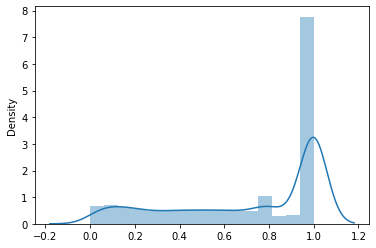

In [339]:
import seaborn as sns
sns.distplot(Xt.data)

### Check transform cosiscenty

In [340]:
#sns.distplot(Xt[:, corrected_column_ordinal.min():corrected_column_ordinal.max()].data)
i = 0
bin_edges_i = rob.bin_edges_[i]
bin_centers_i = rob.bin_centers_[i]

Xord = rob._transform_ordinal(X_test)
column_ordinal = Xord[:,i].astype(int)
temp_df = pd.DataFrame(Xt[:, (rob.col_index_correction_[i]):(rob.col_index_correction_[i+1])].A)
temp_df.columns = rob._encoder.categories[i]
temp_df['bin'] = Xord[:,i]
temp_df['original_value'] = X_test.values[:, i]
temp_df['bin_center'] = bin_centers_i[column_ordinal]
temp_df.loc[column_ordinal == -1,'bin_center'] = np.nan

temp_df

,-1,0,1,2,3,4,5,6,7,8,9,bin,original_value,bin_center
0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,-1.0,NaN,NaN
1,0.0,0.0,0.0,0.0,0.935318,0.064682,0.0,0.0,0.000000,0.0,0.000000,3.0,338.0,331.70
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.076708,0.8,0.123292,8.0,856.0,862.85
3,0.0,0.0,0.0,0.0,0.565708,0.434292,0.0,0.0,0.000000,0.0,0.000000,3.0,374.0,331.70
4,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,-1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,-1.0,NaN,NaN
996,0.0,0.0,0.0,0.0,0.801848,0.198152,0.0,0.0,0.000000,0.0,0.000000,3.0,351.0,331.70
997,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,-1.0,NaN,NaN
998,0.0,0.0,0.0,0.0,0.976386,0.023614,0.0,0.0,0.000000,0.0,0.000000,3.0,334.0,331.70


### Check inverse_transform consistency

In [342]:
Xt[((Xt>0).sum(1) > 9).A.flatten()].A[0]

array([0.        , 0.        , 0.        , 0.        , 0.13517915,
       0.8       , 0.06482085, 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.06617647, 0.8       ,
       0.13382353, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.05189456,
       0.8       , 0.14810544, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [343]:
import seaborn as sns
i = 0
X_ = X_test
Xt = rob.transform(X_)

Xinv = rob._fuzzy_inverse_transform(Xt)[:,i]
#jnt = sns.jointplot(p1,p2)
#jnt.ax_joint.plot([-400,300],[-400,300])

jnt = sns.jointplot(X_.values[:,i], Xinv, alpha = 0.2)
jnt.ax_joint.plot([X.iloc[:,i].dropna().min(),X.iloc[:,i].dropna().max()],[X.iloc[:,i].dropna().min(),X.iloc[:,i].dropna().max()],color = 'r', label = 'identity line in the X_train domain')
jnt.ax_joint.set_xlabel('original X_test values')
jnt.ax_joint.set_ylabel('inverted Xt_test values')
#jnt = sns.jointplot(p3,p2)
#jnt.ax_joint.plot([-400,300],[-400,300])

#old_inv 
#sns.distplot(old_inv[rows_idxs] - X_test.values[rows_idxs,i])

ok
ok
ok
ok


c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\scipy\sparse\compressed.py:291: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


IndexError: index (44) out of range

### Usage example with linear regression

c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


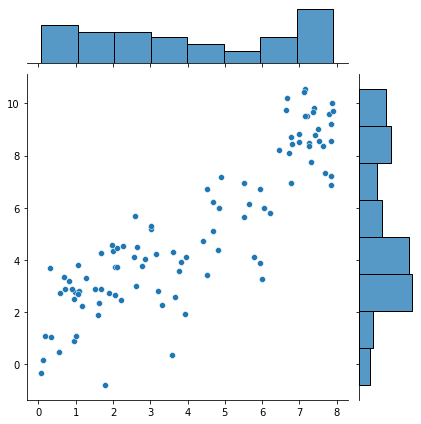

In [377]:
xfunc = lambda x: np.sin(x/3) + np.sin(x) + np.sin(3*x) + x
lendata = 100
noise_ratio = 1
xrange = 8
extrapolation_factor = 0.2

X = xrange*np.random.random(lendata).reshape(-1,1)
X_test = xrange*(np.random.random(lendata).reshape(-1,1)*(1+2*extrapolation_factor) - extrapolation_factor)

y = xfunc(X) + noise_ratio*np.random.randn(X.shape[0], 1)
#true signal without noise in test
y_test = xfunc(X_test) + noise_ratio*np.random.randn(X_test.shape[0], 1)
y_test_denoised = xfunc(X_test)
#X[np.random.choice(np.arange(X.shape[0]), 200)] = np.nan
#X_test[np.random.choice(np.arange(X_test.shape[0]), 200)] = np.nan

sns.jointplot(X.flatten(),y.flatten())

In [394]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

poly_degree = 1
polynomial_transformer = PolynomialFeatures(degree = poly_degree, interaction_only = False, include_bias = False,)

#TODO heuristic for nbins max(4, min(1000, X.shape[0]**(1/2)))
nbins =int(max(4, min(10000, int(np.power(X.shape[0],0.5)))))
#nbins =int(max(4, min(10000, X.shape[0]//30)))
print(nbins)
encoder = RobustKBinsDiscretizer(
    n_bins = nbins,
    encode = 'fuzzy',
    strategy = 'quantile',
    handle_nan = 'ignore',
    fuzzy_alpha=1,
    fuzzy_jump_threshold = 0.0
)

linear_regressor = Ridge(alpha = 0.1,fit_intercept = True, positive = False)

linear_regressor = make_pipeline(polynomial_transformer, linear_regressor)

forest = RandomForestRegressor()

linear_estimator = make_pipeline(encoder,linear_regressor)

forest = ResidualRegressor(
    [linear_regressor,forest],
    residual_split_fraction = None
)

linear_estimator = ResidualRegressor(
    [linear_regressor, linear_estimator],
    residual_split_fraction = None
)

10


In [395]:
encoder.fit_transform(X)[2].A

array([[0.        , 0.        , 0.        , 0.        , 0.68284938,
        0.31715062, 0.        , 0.        , 0.        , 0.        ]])

In [396]:
linear_estimator.fit(X,y)
forest.fit(X,y)

c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\ipykernel_launcher.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


ResidualRegressor(regressors=[Pipeline(steps=[('polynomialfeatures',
                                               PolynomialFeatures(degree=1,
                                                                  include_bias=False)),
                                              ('ridge', Ridge(alpha=0.1))]),
                              RandomForestRegressor()])

c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


kbinned linreg R² score: 0.857
random-forest R² score: 0.861
interpolation kbinned linreg R² score: 0.814
interpolation random-forest R² score: 0.716


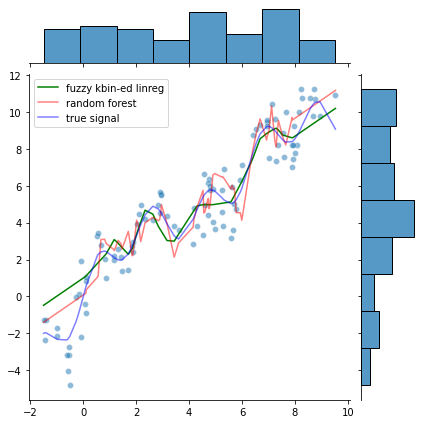

In [397]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

y_pred_lin = linear_estimator.predict(X_test)
y_pred_forest = forest.predict(X_test)

jnt = sns.jointplot(X_test.flatten(),y_test.flatten(), alpha = 0.5)
argsort = np.argsort(X_test.flatten())
jnt.ax_joint.plot(X_test.flatten()[argsort], y_pred_lin.flatten()[argsort], color = 'green', label = 'fuzzy kbin-ed linreg', alpha = 1)
jnt.ax_joint.plot(X_test.flatten()[argsort], y_pred_forest.flatten()[argsort], color = 'red', label = 'random forest', alpha = 0.5)
jnt.ax_joint.plot(X_test.flatten()[argsort], y_test_denoised.flatten()[argsort], color = 'blue', label = 'true signal', alpha = 0.5)
jnt.ax_joint.legend()
print(f'kbinned linreg R² score: {round(r2_score(y_test, y_pred_lin), 3)}')
print(f'random-forest R² score: {round(r2_score(y_test, y_pred_forest), 3)}')

interpolation_msk = (X_test.flatten() <= X.max()) & (X_test.flatten() >= X.min())
#interpolation_msk = ~interpolation_msk
print(f'interpolation kbinned linreg R² score: {round(r2_score(y_test[interpolation_msk], y_pred_lin[interpolation_msk]), 3)}')
print(f'interpolation random-forest R² score: {round(r2_score(y_test[interpolation_msk], y_pred_forest[interpolation_msk]), 3)}')
#print(f'interpolation random-forest R² score: {round(r2_score(y_test, y_test_denoised), 3)}')


## RobustOneHotEncoder

In [1034]:
#export
class RobustOneHotEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(
        self,
        categories = 'auto',
        dtype=np.float64,
        handle_unknown = 'error',# for one hot {'error', 'ignore','handle'}
        drop=None,
        sparse=True,
        nan_value = np.nan, #could be "nan" (Str) for example
        handle_nan = 'handle', #error, handle, ignore        
    ):
        '''
        A robust one hot encoder. Always return the same amount of nonzero value sin each transformed row.
        Has columns for unknown values
        '''
        
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown
        self.drop = drop
        self.sparse = sparse
        self.nan_value = nan_value
        self.handle_nan = handle_nan
        return
                    
    def _nan_msk(self, X):
        """
        check NaNs in special cases like 'O' type arrays
        """
        
        
        if self.nan_value in (np.nan,):
            if X.dtype == 'O':
                nanmsk_ = X == 'nan' #'nan' that are not proper NaNs
                nanmsk = X.astype(str) == 'nan' #proper and not propper NaNs
                #exclude values that had "nan" instead of np.nan
                #if want to count them as valid NaNs, perform transformation upstream
                nanmsk = nanmsk & (~nanmsk_)
            else:
                nanmsk = np.isnan(X)
        else:
            nanmsk = (X == self.nan_value)
        
        return nanmsk
    
    def _check_nan_cols(self, X):
        '''
        returns cols with corresponding with self.nan_value
        '''        
        nanmsk = self._nan_msk(X)
        cols_w_nans = np.nonzero(nanmsk.any(0))[0]
        return cols_w_nans        
        
    def _infer_categories(self, X):
        
        categories = []
        for jj in range(X.shape[1]):            
            
            if self.handle_nan in ('handle','ignore'):
                #if nan handling, create a NaN msk
                if self.nan_value in (np.nan,):
                    if X[:, jj].dtype == 'O':
                        nanmsk_ = X[:, jj] == 'nan' #'nan' that are not proper NaNs
                        nanmsk = X[:, jj].astype(str) == 'nan' #proper and not propper NaNs
                        #exclude values that had "nan" instead of np.nan
                        #if want to count them as valid NaNs, perform transformation upstream
                        nanmsk = nanmsk & (~nanmsk_)
                    else:
                        nanmsk = np.isnan(X[:, jj])
                    
                else:
                    nanmsk = (X[:, jj] == self.nan_value)
                
                #if want to create nan dummies, should include nans do categories
                #even if not found during train
                if self.handle_nan == 'handle':
                    unq = _unique(X[:,jj])
                    
                    if (nanmsk.sum() == 0)  and (self.handle_unknown == 'handle'):
                        #append nan class even if there are no nans in traning
                        #unknown nans are treatted diffrently from unknown non-nans
                        unq = np.append(unq, self.nan_value)
                                            
                    categories.append(unq)
                
                #if nans are to be ignored in dummies, exclude nans in training set
                else:                                        
                    #exclude NaNs and append only other categories
                    #case where handle_nan is set to ignore or create_nan_dummy is set to False
                    categories.append(_unique(X[~nanmsk,jj]))
            
            #if not handle_nan, appends regular unique categories
            #nan checking is assumed to be performed upstream
            else:
                categories.append(_unique(X[:,jj]))
            
        return categories            
            
    def fit(self, X, y = None, **kwawrgs):                                
        
        #check array
        X = check_array(X, dtype = None, force_all_finite = 'allow-nan')
        #check nans
        if self.handle_nan == 'error':
            nancols = self._check_nan_cols(X).tolist()
            if nancols:
                raise ValueError(f'Columns {[i for i in nancols]} has NaN Values set to {self.nan_value} ({type(self.nan_value)})')        
        
        ordinal_handle = 'use_encoded_value' if self.handle_unknown in ('handle','ignore') else 'error'
        if self.categories == 'auto':
            ordinal_categories = self._infer_categories(X)
        else:
            ordinal_categories =self.categories
            
        self.ordinalencoder_ = OrdinalEncoder(
            handle_unknown = ordinal_handle,
            unknown_value = -1 if ordinal_handle == 'use_encoded_value' else None,
            categories = ordinal_categories,
            dtype = self.dtype,            
        ).fit(X)        
        
        X = self.ordinalencoder_.transform(X)
        
        
        if self.handle_unknown in ('ignore', 'error'):
            #ordinal encoder returns a category called nan instead of ordinal index when nans are passed in input
            onehot_categories = []
            for cats in self.ordinalencoder_.categories_:
                if self._nan_msk(cats).sum() == 0:
                    onehot_categories.append(np.arange(0, len(cats)))
                else:
                    cts = np.arange(0, len(cats)).astype(cats.dtype)
                    cts[-1] = np.nan
                    onehot_categories.append(cts)                
        else:
            #ordinal encoder returns a category called nan instead of ordinal index when nans are passed in input
            onehot_categories = []
            for cats in self.ordinalencoder_.categories_:
                if self._nan_msk(cats).sum() == 0:
                    onehot_categories.append(np.arange(-1, len(cats)))
                else:
                    cts = np.arange(-1, len(cats)).astype(cats.dtype)
                    cts[-1] = np.nan
                    onehot_categories.append(cts)                
        
        onehot_handle = 'error' if (self.handle_unknown == 'error') else 'ignore'
        self.onehotencoder_ = OneHotEncoder(
            categories = onehot_categories,
            drop = self.drop,
            sparse = self.sparse,
            dtype = self.dtype,
            handle_unknown = onehot_handle
        ).fit(np.zeros((1, X.shape[1]))) #fit with toy dataset since categories are passed
        
        return self
    
    def transform(self, X, **kwargs):
        #check array
        X = check_array(X, dtype = None, force_all_finite = 'allow-nan')
        check_is_fitted(self)
        X = self.ordinalencoder_.transform(X)
        X = self.onehotencoder_.transform(X)
        return X

In [1035]:
#X = np.random.randn(1000,2)
vec_chr = np.vectorize(chr)

X = np.random.randint(10,100+10,(10000,2))#.astype(float)
#X = vec_chr(X)
X = pd.DataFrame(X)
X.iloc[np.random.choice(np.arange(X.shape[0]), size = 500, replace = False)] = np.nan
#X[:,1] = np.random.randn(1000,)

X_test = np.random.randint(10,100+10,(1000,2))#.astype(float)
X_test = vec_chr(X_test)
X_test = pd.DataFrame(X_test)
X_test.iloc[np.random.choice(np.arange(X_test.shape[0]), size = 500, replace = False)] = np.nan
#X_test[:,0] = np.random.randn(1000,)


In [387]:
enc = RobustOneHotEncoder(
    handle_unknown = 'handle', handle_nan = 'handle'
).fit(X)

In [388]:
enc.transform(X_test)

<1000x204 sparse matrix of type '<class 'numpy.float64'>'
	with 2000 stored elements in Compressed Sparse Row format>

## CBHML (community based heterogeneous space manifold learning)

In [1205]:
#export
#community based heterogeneous space manifold learning
class CBHML(TransformerMixin, BaseEstimator):
    
    def __init__(
        self,
        network_embedder,        
        linear_estimator = None,
        bipartite = True,
        max_archetypes = None,
        normalize = True,
        return_sparse = False,
        numerical_features = [],
        categorical_features = [],
        bag_features = [],
        passthrough_features = [],
        numerical_pipeline = None,
        categorical_pipeline = None,
        bag_pipeline = None,
        numerical_n_bins = 10,
        numerical_fuzzy = True,
        numerical_strategy='quantile',
        numerical_handle_nan = 'ignore',
        categorical_nan_value = np.nan,
        categorical_handle_nan = 'ignore',
        categorical_handle_unknown = 'ignore',
        bag_nan_value = np.nan,
        bag_handle_nan = 'ignore',
        bag_handle_unknown = 'ignore',        
        n_jobs = None,
        
    ):
        self.linear_estimator = linear_estimator
        self.network_embedder = network_embedder
        self.max_archetypes = max_archetypes #max number of greater than zero embedding dimensions
        self.normalize = normalize
        self.return_sparse = return_sparse
        self.bipartite = bipartite #whether to perform comunity detection in kernelized feature space or in point-feature biaprtite graph
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.bag_features = bag_features
        self.passthrough_features = passthrough_features
        self.numerical_pipeline = numerical_pipeline
        self.categorical_pipeline = categorical_pipeline
        self.bag_pipeline = bag_pipeline
        self.numerical_n_bins = numerical_n_bins
        self.numerical_fuzzy = numerical_fuzzy
        self.numerical_strategy = numerical_strategy
        self.numerical_handle_nan = numerical_handle_nan
        self.categorical_handle_nan = categorical_handle_nan
        self.categorical_handle_unknown = categorical_handle_unknown
        self.categorical_nan_value = categorical_nan_value
        self.bag_handle_nan = bag_handle_nan
        self.bag_handle_unknown = bag_handle_unknown
        self.bag_nan_value = bag_nan_value
        self.n_jobs = n_jobs
        return
    
    def _make_preprocess_pipeline(self,):
        '''
        create preprocessing pipeline for features
        '''
        if self.numerical_pipeline is None:            
            numerical_pipeline = RobustKBinsDiscretizer(
                n_bins = self.numerical_n_bins,
                handle_nan = self.numerical_handle_nan,
                strategy = self.numerical_strategy, 
                encode = 'fuzzy' if self.numerical_fuzzy else 'onehot',
            )
        else:
            numerical_pipeline = self.numerical_pipeline
        
        if self.categorical_pipeline is None:
            categorical_pipeline = RobustOneHotEncoder(
                handle_unknown = self.categorical_handle_unknown,
                handle_nan = self.categorical_handle_nan
            )
        else:
            categorical_pipeline = self.categorical_pipeline
        
        if self.bag_pipeline is None:
            #TODO: define default bag_pipeline
            bag_pipeline = 'drop'#self.bag_pipeline
        else:
            bag_pipeline = self.bag_pipeline
        
        #if no features to passthrough, drop, else apply passthrough
        if self.passthrough_features == []:
            passthrough_pipe = 'drop'            
        else:
            passthrough_pipe = 'passthrough'                        
        
        preprocess_pipeline = ColumnTransformer(
            [
                ('numerical_pipeline',numerical_pipeline, self.numerical_features),
                ('caregorical_pipeline',categorical_pipeline, self.categorical_features),
                ('bag_pipeline',bag_pipeline, self.bag_features),
                ('passthrough_pipeline', passthrough_pipe, self.passthrough_features),
            ],
            n_jobs = self.n_jobs
        )
        return preprocess_pipeline
    
    def fit(self, X, y = None, **kwargs):
        '''
        fits linear estimator, sets wieghts and fits graph embedder
        '''
        #parse sample_weight
        if 'sample_weight' in kwargs:
            sample_weight = kwargs['sample_weight']
        else:
            sample_weight = None
            
        #parse max_archetypes
        if not self.max_archetypes is None:
            if type(self.max_archetypes) == int:
                if not self.max_archetypes > 0:
                    raise ValuerError(f'if int, max archetypes should be greater than 0, got {self.max_archetypes}')
                else:
                    pass
            elif type(self.max_archetypes) == float:                
                if not (self.max_archetypes > 0) and (self.max_archetypes < 1):
                    raise ValuerError(
                        f'if float, max archetypes should be in range 0 < max_arcgetypes < 1, got {self.max_archetypes}'                        
                    )
                else:
                    pass
            else:
                raise ValuerError(
                        f'max_archetypes should be None, float or int. got {type(self.max_archetypes)}'
                    )
                        
        #fit preprocess pipeline
        preprocess_pipeline_ = self._make_preprocess_pipeline().fit(X, y)
        #transform X
        Xt = preprocess_pipeline_.transform(X)
        
        # fit linear estimator if passed (metric learning)
        if not self.linear_estimator is None:
            self.linear_estimator.fit(X=Xt, y=y, **kwargs)
            #get feature importances
            feature_importances_ = self.linear_estimator.coef_
        else:
            feature_importances_ = np.ones(Xt.shape[1])
        
        if feature_importances_.ndim == 1:
            #regression case
            feature_importances_ = np.abs(feature_importances_)
        else:
            #multiclass case
            feature_importances_ = np.abs(feature_importances_).sum(0)
        
        #scale feature space
        if not sample_weight is None:            
            Xt = Xt.multiply(sample_weight.reshape(-1,1)) #multiply by column matrix of sample_weight
        
        Xt = Xt.multiply(feature_importances_.reshape(1,-1)) #multiply by row matrix of feature weights
        #add a small amount of noise to make sum positive, if needed
        if Xt.sum() == 0:
            Xt+= np.abs(np.random.randn(1)*1e-8)
        #fit graph embedder
        if self.bipartite:
            Xt = sparse.csr_matrix(Xt)
            self.network_embedder.fit(Xt)            
            features_membership_matrix_ = self.network_embedder.membership_col_
            feature_labels_ = self.network_embedder.labels_col_
            
        else:
            Xt = sparse_dot_product(Xt.T, Xt, ntop = Xt.shape[1]) #flexible dot product. if sparse_dot_topn not instaled, perform scipy dot product            
            self.network_embedder.fit(Xt)            
            features_membership_matrix_ = self.network_embedder.membership_
            feature_labels_ = self.network_embedder.labels_
        
        #get topn archetyes
        total_archetypes_ = features_membership_matrix_.shape[-1]
        if not self.max_archetypes is None:
            if type(self.max_archetypes) == float:
                topn_archetypes_ = int(max(1, round(total_archetypes_*self.max_archetypes, 0)))                
            else: #int case
                topn_archetypes_ = min(total_archetypes_, self.max_archetypes)
        else:
            topn_archetypes_ = total_archetypes_
        
        if topn_archetypes_ == total_archetypes_:
            subset_archetypes_ = False
        else:
            subset_archetypes_ = True
        
        #save only feature embeddings dims that have at least one value
        features_membership_matrix_ = features_membership_matrix_[:, (features_membership_matrix_.sum(0) > 0).A.flatten()]
        #save state
        self.subset_archetypes_ = subset_archetypes_
        self.topn_archetypes_ = topn_archetypes_
        self.preprocess_pipeline_ = preprocess_pipeline_
        self.features_membership_matrix_ = features_membership_matrix_
        self.feature_importances_ = feature_importances_
        return self
    
    def transform(self, X, return_sparse = None):
        #parse return_sparse argumento
        if return_sparse is None:
            return_sparse = self.return_sparse
        
        Xt = self.preprocess_pipeline_.transform(X)
        Xt = Xt.multiply(self.feature_importances_.reshape(1,-1)) #multiply by row matrix of feature weights
        Xt = sparse_dot_product(Xt, self.features_membership_matrix_, ntop = self.features_membership_matrix_.shape[0]) #TODO: decide whether to normalize (non noramlization yields a "confidence" score, since rows with many NaNs will have lower norm)
        Xt = Xt.A
        if self.subset_archetypes_:                        
            topn = np.argsort(Xt, axis = 1)[:,:-self.topn_archetypes_]
            Xt.put((topn + np.arange(Xt.shape[0]).reshape(-1,1)*Xt.shape[1]).flatten(), 0)
        if self.normalize:
            #Xt = normalize(Xt, norm = 'l1')
            Xt = softmax(Xt, 1)
            
        if return_sparse:
            Xt = sparse.csr_matrix(Xt)
        else:
            pass
        
        return Xt
    

In [1206]:
from sklearn.datasets import fetch_california_housing
import seaborn as sns
housing = fetch_california_housing(as_frame = True)
df, features, target = housing['frame'], housing['feature_names'], housing['target_names']

In [1207]:
from sknetwork.embedding import LouvainEmbedding

reg = SGDRegressor(penalty = 'l2', alpha = 0.01,)
#reg = LinearRegression()
clf = LogisticRegression()

embeder = Louvain()

In [1213]:
y = df[target]
y_cat = RobustKBinsDiscretizer(encode = 'ordinal', ).fit_transform(y)

pureg = CBHML(
    embeder, reg, numerical_features = features, numerical_n_bins = 100, numerical_strategy = 'quantile', bipartite = True,
    max_archetypes = None, normalize = True, numerical_fuzzy = True,
).fit(df, y)
#puclf = CBHML(clf, embeder, numerical_features = features, numerical_n_bins = 20, numerical_strategy = 'quantile').fit(df, y_cat)

c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RobustKBinsDiscretizer was fitted with feature names
  "X does not have valid feature names, but"
c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\ipykernel_launcher.py:130: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RobustKBinsDiscretizer was fitted with feature names
  "X does not have valid feature names, but"
c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RobustKBinsDiscretizer was fitted with feature names
  "X does not have valid feature names, but"
c:\users\user ambev\desktop\mypackages\replan\venv\l

c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RobustKBinsDiscretizer was fitted with feature names
  "X does not have valid feature names, but"
c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

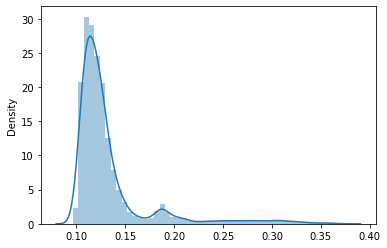

In [1214]:
sns.distplot(pureg.transform(df).max(1))

c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RobustKBinsDiscretizer was fitted with feature names
  "X does not have valid feature names, but"


membership
0     4040
1     3790
2     2514
3     1772
4     1717
5     1451
6     1230
7     1168
8     1170
9      897
10     891
Name: y, dtype: int64

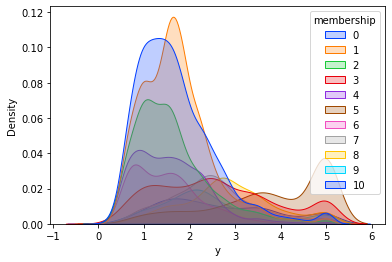

In [1228]:
embs = pureg.transform(df)
point_membership = pd.DataFrame(embs.argmax(1))
msk = embs.max(1) > 0
point_membership.columns = ['membership']
point_membership['membership'] = pureg.network_embedder.labels_row_
point_membership['y'] = df[target]
point_membership['score'] = embs.max(1)

sns.kdeplot(data = point_membership[msk], x = 'y',hue = 'membership', palette = 'bright', shade = True, )
point_membership[msk].groupby('membership')['y'].count()

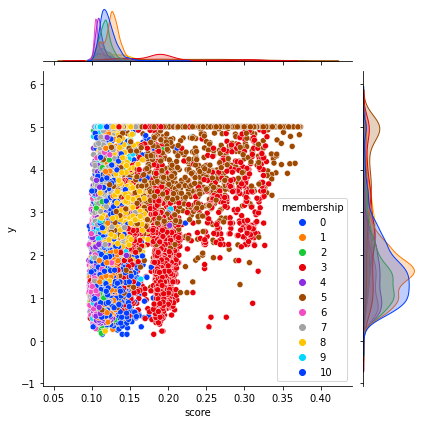

In [1229]:
#sns.scatterplot(data = point_membership[msk], x = 'score', y = 'y', hue = 'membership', palette = 'bright', shade = True, )
sns.jointplot(data = point_membership[msk], x = 'score', y = 'y', hue = 'membership', palette = 'bright')

c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

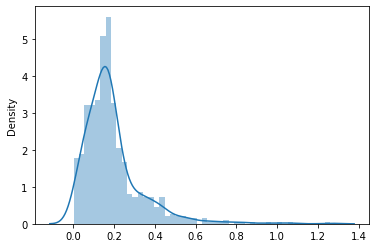

In [1230]:
import seaborn as sns
sns.distplot(np.abs(pureg.linear_estimator.coef_))

In [1235]:
from sklearn.decomposition import PCA, TruncatedSVD
import pandas as pd

embs2d = TruncatedSVD(2, random_state = 42).fit_transform(embs)

c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='X0', ylabel='X1'>

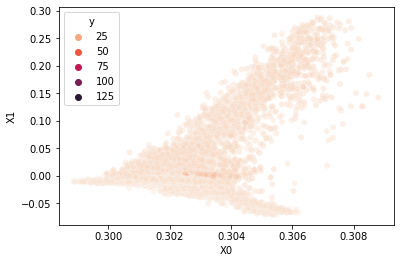

In [1241]:
embsdf = pd.DataFrame(embs2d)
embsdf.columns = [f'X{i}' for i in range(embs2d.shape[-1])]
embsdf['y'] = y#
embsdf['y'] = df.iloc[:,2]

#fig = px.scatter_3d(embsdf, x='X0', y='X1', z='X2',
#              color='y',opacity = 0.2)
sns.scatterplot(embsdf['X0'], embsdf['X1'], hue = embsdf['y'], alpha = 0.4, palette = 'rocket_r')

## RePLAN

In [1173]:
class _RePLAN():
    
    def __init__(
        self,
        base_partition_unit,
        max_depth = None,    
        min_membership_score = None, #membership scores get diluted for each new level, so the sum of membership of a point accross all archetypes sum to 1
        min_sample_leaf = 40,
        max_discrepancy_split = None,
        #max_models = None, deprecated since tree is grown recursively, and druing construction, algorithm focuses on depth first
        #max_archetypes = None,
        validation_metric = None,
        validation_split = None
    ):
        '''
        Recursive structure to partition 
        
        min_points_leaf: min points in a leaf model in order to perform a new split
        depth: ammount of levels to build the tree
        min_membership_score: membership scores threshold in order to stop growing spliting further
        max_models: after reaching this ammount of models, tree growing is stoped
        max_archetypes: after reaching this ammount of archetypes, tree growing is stoped
        '''
        
        self.base_partition_unit = base_partition_unit
        self.max_depth = max_depth
        self.min_membership_score = min_membership_score    
        self.min_sample_leaf = min_sample_leaf
        self.max_discrepancy_split = max_discrepancy_split #max discrepancy value (#points_in_largest_child/#points_in_2nd_largest_child) in which further splits are performed
        self.validation_metric = validation_metric
        self.validation_split = validation_split
        return
    
    def _check_stopping_criteria(self, parent_name, embeddings, y, level):
        #calculate embs msk
        embs_msk = embeddings>0
        ###check global criteria
        #check depth        
        #set global mask do false (non leaf)
        global_msk = np.zeros(shape = (embeddings.shape[1],), dtype = bool)
        if not self.max_depth is None:
            if level >= self.max_depth:
                #set all as leaf in global msk
                global_msk = np.ones(shape = (embeddings.shape[1],), dtype = bool)
        ###check parent node criteria
        ##check ML metrics
        parent_msk = np.zeros(shape = (embeddings.shape[1],), dtype = bool)
        if self.validation_metric:
            metric = self.G_[parent_name][self.validation_metric]
            if metric <= self.min_validation_value:
                #set all as leaf
                mlmetrics_msk = np.ones(shape = (embeddings.shape[1],), dtype = bool)
                parent_msk = parent_msk|mlmetrics_msk
        
        ##check parent discrepancy
        if not self.max_discrepancy_split is None:
            archetypes_sum = embs_msk.sum(0)
            sorted_archetypes_sum = archetypes_sum[np.argsort(archetypes_sum)]            
            discrepancy = sorted_archetypes_sum[-1]/sorted_archetypes_sum[-2]            
            if discrepancy > self.max_discrepancy_split:
                discrepancy_msk = np.ones(shape = (embeddings.shape[1],), dtype = bool)
                parent_msk = parent_msk|discrepancy_msk
        
        ###check local (children node) criteria                    
        #set children_msk to false (all non leafs)
        children_msk = np.zeros(shape = (embeddings.shape[1],), dtype = bool)
        #check if leaf node has atleast n samples
        if not self.min_sample_leaf is None:
            min_sample_leaf_msk = embs_msk.sum(0) < self.min_sample_leaf
            children_msk = children_msk|min_sample_leaf_msk
        if not self.min_membership_score is None:
            nonzero_avgs = np.nanmean(np.where(embs_msk, embeddings, np.nan), axis = 0) #mean of nonzeros
            min_membership_score_msk = (nonzero_avgs < self.min_membership_score)
            children_msk = children_msk|min_membership_score_msk        
        
        ##check purity
                                
        return global_msk|parent_msk|children_msk #atleast one satisfy the condition for it to be a children node
    
    
    def fit(self, X, y = None, **kwargs):
        #parse purity criteria
        #parse ML metric criteria
        #create graph
        self.G_ = nx.DiGraph()
        #fit root node
        root_estim = clone(self.base_partition_unit)
        root_estim, metrics = self._fit_estim(root_estim, X=X, y=y, parent_weight = None, **kwargs)        
        #append to tree
        self.G_.add_node('0', estimator = root_estim, is_root = True, is_leaf = False, **metrics)
        embs = root_estim.transform(X)                
        #fit children nodes recursively (depth first)
        self._fit_children(X, y, parent_name = '0', parent_membership_score=None, level=1)        
        #save states        
        self.leaf_nodes_ = tuple(i for i in self.G_.nodes if self.G_.nodes[i]['is_leaf'])
        self.n_archetypes_ = len(self.leaf_nodes_)
        return self
        
        
    def _fit_children(self, X, y = None, parent_name = None, parent_membership_score = None, level = 1, **kwargs):
        #get embeddings
        embeddings = self.G_.nodes[parent_name]['estimator'].transform(X)
        if not parent_membership_score is None:
            embeddings = embeddings*parent_membership_score.reshape(-1,1)
        
        embs_msk = embeddings>0
        
        leaf_children_msk = self._check_stopping_criteria(parent_name=parent_name, embeddings=embeddings, y=y, level=level)
        #fit children nodes
        for i in range(len(leaf_children_msk)):
            child_name = parent_name + f'-{i}'
            is_leaf = leaf_children_msk[i]
            if is_leaf:
                self.G_.add_node(child_name, estimator = None, is_root = False, is_leaf = True)
                self.G_.add_edge(parent_name, child_name)

            else:
                point_mask = embs_msk[:, i]
                Xc = X[point_mask] #X points routed to children node
                yc = y[point_mask] #y points routed to children node
                Pwc = embeddings[point_mask, i] #parent membership scores for given archetype
                Swc = kwargs['sample_weight'][point_mask] if 'sample_weight' in kwargs else None #sample_weight
                #fit children estimator
                child_estim = clone(self.base_partition_unit)
                child_estim, metrics = self._fit_estim(child_estim, X=Xc, y=yc, parent_weight=Pwc, sample_weight=Swc)
                #create children node in graph
                self.G_.add_node(child_name, estimator = child_estim, is_root = False, is_leaf = False, **metrics)
                self.G_.add_edge(parent_name, child_name)
                #recursive fit children
                self._fit_children(X=Xc, y=yc, parent_name=child_name, parent_membership_score = Pwc, level=level+1, **kwargs)
            
        return self
        
        
    def _fit_estim(self, estim, X, y = None, parent_weight = None, sample_weight = None):
        
        if parent_weight is None:
            parent_weight = np.ones(X.shape[0])
        if sample_weight is None:
            sample_weight = np.ones(X.shape[0])
                
        total_weight = sample_weight * parent_weight        
        
        metrics = {}
        if not self.validation_metric is None:
            #split train and validation
            #...
            #fit estimator with train set
            estim.fit(X = X, y = y, sample_weight = total_weight)            
            #calculate validation metric on holdout set
            metric_value = None
            metrics = {self.validation_metric: metric_value}
        else:
            #fit with full data
            estim.fit(X = X, y = y, sample_weight = total_weight)
        return estim, metrics
    
    
    def _transform(self, X):
                                        
        root_embeddings = self.G_.nodes['0']['estimator'].transform(X)        
        embs_msk = root_embeddings>0                
        results = {}
        for child_name in self.G_.successors('0'):
            i = int(child_name.split('-')[-1])
            nonzero_indexes = np.nonzero(embs_msk[:,i])[0]         
            local_embs = root_embeddings[nonzero_indexes, i]
            if child_name in self.leaf_nodes_:                
                results[child_name] = (nonzero_indexes,local_embs) #tuple of values and indexes for a given archetype
            else:                                
                Pwc = local_embs #parent membership scores for given archetype in children node c           
                results = self._children_transform(
                    X = X,
                    node_name = child_name,
                    results = results,
                    parent_membership_score = Pwc,
                    global_parent_row_indexes = nonzero_indexes
                )

        return results
    
    
    def _children_transform(self, X, node_name = '0', results = {}, parent_membership_score = None, global_parent_row_indexes = None):
        
        if hasattr(X, 'iloc'):            
            X_sub = X.iloc[global_parent_row_indexes]
        else:
            X_sub = X[global_parent_row_indexes]
                
        embeddings = self.G_.nodes[node_name]['estimator'].transform(X_sub)
        if not parent_membership_score is None:
            embeddings = embeddings*parent_membership_score.reshape(-1,1)

        embs_msk = embeddings>0                
        node_name_results = []
        for child_name in self.G_.successors(node_name):
            i = int(child_name.split('-')[-1])
            local_nonzero_indexes = np.nonzero(embs_msk[:,i])[0]
            global_nonzero_indexes = global_parent_row_indexes[local_nonzero_indexes]
            local_embs = embeddings[local_nonzero_indexes, i]
            if child_name in self.leaf_nodes_:                
                results[child_name] = (global_nonzero_indexes,local_embs) #tuple of values and indexes for a given archetype
            else:
                #Xc = X[point_idxs] #X points routed to children node c
                Pwc = local_embs #parent membership scores for given archetype in children node c           
                results = self._children_transform(
                    X,
                    node_name = child_name,
                    results = results,
                    parent_membership_score = Pwc,
                    global_parent_row_indexes = global_nonzero_indexes
                )                    
        
        return results
    
    def transform(self,X):
        results = self._transform(X)
        #parse dict into sparse matrix
        return
        

In [1181]:
X = df.drop(columns = target)

In [1186]:
reg = SGDRegressor(penalty = 'l2', alpha = 0.01,)
embeder = Louvain()
pureg = CBHML(
    embeder, reg, numerical_features = features, numerical_n_bins = 10, numerical_strategy = 'quantile', bipartite = False,
    max_archetypes = 3, normalize = False
)
replan = _RePLAN(
    pureg,
    max_depth = 3,
    min_sample_leaf = 100,
    max_discrepancy_split=1.5,
    min_membership_score=None
)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [1191]:
#res = replan._transform(pd.concat([df]*10, axis = 0))
pd.concat([df]*10, axis = 0)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [768]:
warnings.filterwarnings('ignore')
%timeit -n 1 -r 1 RandomForestRegressor(min_samples_leaf = 10).fit(X,y)
%timeit -n 1 -r 1 replan.fit(X, y)

7.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.94 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [769]:
replan.n_archetypes_

440

In [618]:
list(replan.G.successors('0'))

['0-0', '0-1', '0-2', '0-3', '0-4', '0-5', '0-6', '0-7', '0-8', '0-9']